# Imports and Functions

In [8]:
import time
import os
import pandas as pd
import numpy as np
import math
import cmath


import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller

In [9]:
##IMPORTANT: use this on the native dataframe (likely in another notebook). 
def pre_merge_clean_holidays(df):
    df["date"] = pd.to_datetime(df["date"]).dt.date

    df["description"] = df["description"].str.replace(r'\+\d+$', '', regex=True) #removes +n from specific holidays
    df["description"] = df["description"].str.replace(r'\-\d+$', '', regex=True) #removes -n from specific holidays

    new_holidays_col_names = {
        "description":"holiday_description",
        "type":"holiday_type"
    }
    df.rename(columns=new_holidays_col_names, inplace=True)

    return df


def pre_merge_clean_oil(df):
    df["date"] = pd.to_datetime(df["date"]).dt.date
    
    df = df.interpolate(method="linear")

    df.rename(columns={"dcoilwtico":"dol_per_barrel"}, inplace=True)
    
    return df

def pre_merge_clean_stores(df):
    new_stores_col_names = {
        "type":"store_type",
        "cluster":"store_cluster",
        "transactions":"store_transactions_per_day"
    }
    df.rename(columns=new_stores_col_names, inplace=True)

    return df

# def merge_creation

def post_merge_cleaning(df):
    ##interpolate oil  
    df = df.interpolate(method="linear")

    df["date"] = pd.to_datetime(df["date"]) #re-instantiatind a pliable format

    ##lag feature creation

    #lag feature creation
    deduplicated = df.groupby(["date", "store_nbr"], as_index=False)["transactions"].first() #2023-01-01 actually only appears once here for one store...probably have to omit

    deduplicated["rolling_30day_avg_traffic"] = deduplicated.groupby("store_nbr")["transactions"].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
    deduplicated["rolling_15day_avg_traffic"] = deduplicated.groupby("store_nbr")["transactions"].transform(lambda x: x.rolling(window=15, min_periods=1).mean())


    intra_col_merge_keys = ["date", "store_nbr", "rolling_30day_avg_traffic", "rolling_15day_avg_traffic"]
    df = df.merge(deduplicated[intra_col_merge_keys], on=[intra_col_merge_keys[0], intra_col_merge_keys[1]], how="left")
        ##include the drop of the NaNs set from the lag feature creation

    ##day of week

    def make_train_test(df):
        ##max date subtracted by 15 and output as test
        pass

    return df



def run_base_df():
    transx = pd.read_csv("../data/transactions.csv")
    stores = pd.read_csv("../data/stores.csv")
    oil = pd.read_csv("../data/oil.csv")
    holidays = pd.read_csv("../data/holidays_events.csv")

    training = pd.read_csv("../data/train.csv")
    # testing = pd.read_csv("../data/test.csv")
    # sample = pd.read_csv("../data/sample_submission.csv")

    dated_dfs = [transx, oil, holidays, training] #oil, holidays,
    # testing["date"] = pd.to_datetime(testing["date"]) #this is to show how we'll tag our testing df with all the pre-processing we need {A function will be the result of housing all the cleaning}

    for df in dated_dfs:
        df["date"] = pd.to_datetime(df["date"]).dt.date
        # print(type(df["date"][0]))

    holidays = pre_merge_clean_holidays(holidays)
    oil = pre_merge_clean_oil(oil)
    stores = pre_merge_clean_stores(stores)

    #Training
    print("Training")
    base_df = pd.merge(training, stores, on="store_nbr", how="inner")
    base_df = base_df.set_index("id")
    base_df = pd.merge(base_df, transx, on=["date", "store_nbr"], how="inner")
    base_df = pd.merge(base_df, oil, on="date", how="left")
    base_df = pd.merge(base_df, holidays, on="date", how="left")

    base_df = post_merge_cleaning(base_df)

    return base_df

def sinlge_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=30, last_n_dates=15):
    
    ##Apply filter
    base_df = base_df[
        (base_df["store_nbr"] == 45) &
        (base_df["family"] == "GROCERY I")
    ]

    ##Assert date_index
    base_df["date_index"] = base_df["date"]
    base_df.set_index("date_index", inplace=True)

    ##One hot cols
    one_hot_columns = [
        "family",
        "city",
        "state",
        "store_type",
        "holiday_type",
        "locale",
        "locale_name",
        "holiday_description",
        "transferred"
    ]
    one_hot_prep_df = base_df[one_hot_columns]
    one_hot_prep_df = one_hot_prep_df.fillna("no_holiday")
    encoder = OneHotEncoder()
    encoded = encoder.fit_transform(base_df[one_hot_columns])
    encoded_dense = encoded.toarray()
    encoded_df = pd.DataFrame(encoded_dense, columns=encoder.get_feature_names_out(one_hot_columns), index=base_df.index)


    ##Day of Week encoding
    base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
    base_df["day_of_week"] = base_df["date"].dt.day_name()
    DAY_OF_WEEK_HIERARCHY_DICT = {
        "Sunday":1, 
        "Monday":2,
        "Tuesday":3,
        "Wednesday":4,
        "Thursday":5,
        "Friday":6,
        "Saturday":7
    }
    niche_df = base_df.copy()
    niche_df = niche_df[["day_of_week"]]
    niche_df["day_of_week_hierarchy_encoded"] = niche_df["day_of_week"].map(DAY_OF_WEEK_HIERARCHY_DICT)
    niche_df["day_of_week_sine"] = np.sin(2 * np.pi * niche_df["day_of_week_hierarchy_encoded"] / 7)
    niche_df["day_of_week_cosine"] = np.cos(2 * np.pi * niche_df["day_of_week_hierarchy_encoded"] / 7)
    niche_df.drop(columns=["day_of_week", "day_of_week_hierarchy_encoded"], inplace=True)



    ##Model_df generation
    model_df = base_df.copy()
    model_df = model_df[["date", "family", "sales", "dol_per_barrel", "rolling_15day_avg_traffic", "rolling_30day_avg_traffic", "store_nbr"]]

    #Weird redundant cleaning, but it works (this step will repeat)
    model_df = model_df[~model_df.index.duplicated(keep="first")]
    
    #Concat
    model_df = pd.concat([model_df, niche_df, encoded_df], axis=1)

    #Weird redundant cleaning, but it works (this step will repeat)
    model_df = model_df[~model_df.index.duplicated(keep="first")]
    model_df.dropna(inplace=True)
    model_df.sort_values(by=["date", "store_nbr", "family"], ascending=True)

    #n_date cutting (train, test, split)
    first_n_dates = model_df["date"].drop_duplicates().head(first_n_dates) 
    last_n_dates = model_df["date"].drop_duplicates().tail(last_n_dates) 
    model_train = model_df[
        (~model_df["date"].isin(first_n_dates)) &
        (~model_df["date"].isin(last_n_dates))
    ]
    model_test = model_df[
        (model_df["date"].isin(last_n_dates))
    ]
    X_train = model_train.drop(columns=["sales", "family", "date"])
    y_train = model_train["sales"]
    X_test = model_test.drop(columns=["sales", "family", "date"])
    y_test = model_test["sales"]

    #Weird redundant cleaning, but it works (this step will repeat)
    X_train.dropna(inplace=True)
    y_train.dropna(inplace=True)
    X_test.dropna(inplace=True)
    y_test.dropna(inplace=True)

    #Set index frequency encoding
    X_train = X_train.asfreq("D")
    y_train = y_train.asfreq("D")

    X_test = X_test.asfreq("D")
    y_test = y_test.asfreq("D")

    #Weird redundant cleaning, but it works (this step will repeat)
    X_train.drop_duplicates(keep="first")
    y_train.drop_duplicates(keep="first")
    X_test.drop_duplicates(keep="first")
    y_test.drop_duplicates(keep="first")
    X_train.fillna(0, inplace=True)
    y_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)
    y_test.fillna(0, inplace=True)

    return X_train, y_train, X_test, y_test


# Data

In [ ]:
base_df = run_base_df()
# X_train, y_train, X_test, y_test = sinlge_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=30, last_n_dates=15)

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


Training


/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:40: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:134: SettingWithCopyWarning: 
A value is trying to be set on a

-----------------------------------
RMSLE Score:0.15557378064687116
RMSE Score:1844.2703217080293
Mean Score:9712.663009744214
RMSE as percentage of the mean: 18.99%


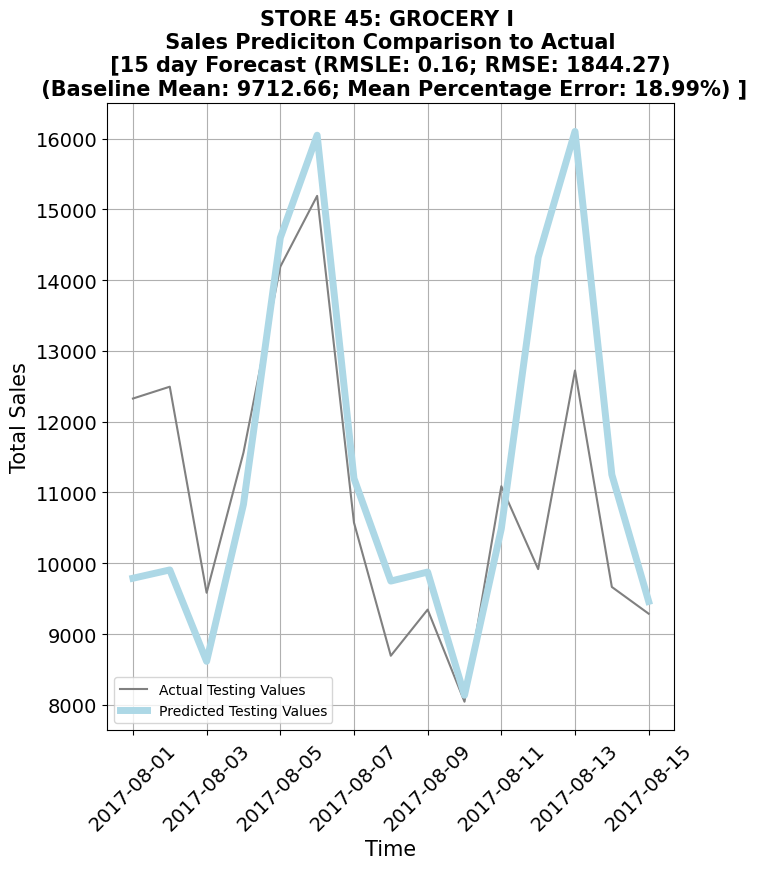

In [17]:
first_n_dates=30
last_n_dates=15 #30 days visually adhere's well

X_train, y_train, X_test, y_test = sinlge_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)

rmsle = np.sqrt(mean_squared_log_error(y_test_clipped, forecast_clipped))
rmse = np.sqrt(mean_squared_error(y_test_clipped, forecast_clipped))
target_mean = y_train.mean()
rmse_percentage = (rmse / target_mean) * 100



print("-----------------------------------")
print(f"RMSLE Score:{rmsle}")
print(f"RMSE Score:{rmse}")
print(f"Mean Score:{target_mean}")
print(f"RMSE as percentage of the mean: {rmse_percentage:.2f}%")



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))

plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (RMSLE: {rmsle.round(2)}; RMSE: {rmse.round(2)}) \n (Baseline Mean: {target_mean.round(2)}; Mean Percentage Error: {rmse_percentage.round(2)}%) ]", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../images/{last_n_dates}_day_model.png", format="png", dpi=300)

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:134: SettingWithCopyWarning: 
A value is trying to be set on a

-----------------------------------
RMSLE Score:0.12426254966257097
RMSE Score:1453.459654574384
Mean Score:9697.7244388445
RMSE as percentage of the mean: 14.99%


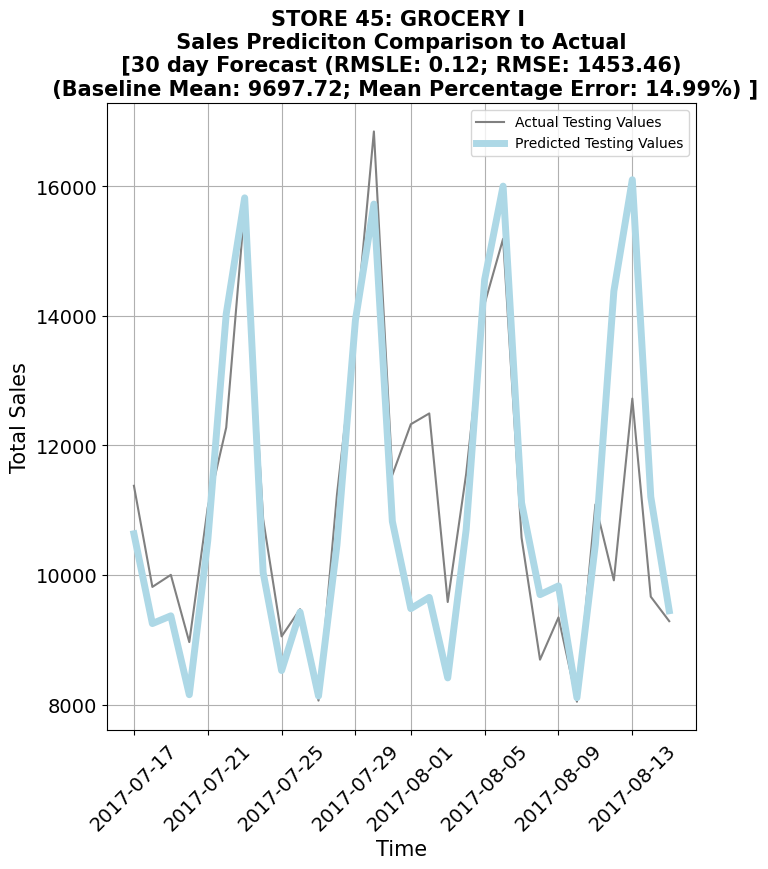

In [18]:
first_n_dates=30
last_n_dates=30 #30 days visually adhere's well

X_train, y_train, X_test, y_test = sinlge_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)

rmsle = np.sqrt(mean_squared_log_error(y_test_clipped, forecast_clipped))
rmse = np.sqrt(mean_squared_error(y_test_clipped, forecast_clipped))
target_mean = y_train.mean()
rmse_percentage = (rmse / target_mean) * 100



print("-----------------------------------")
print(f"RMSLE Score:{rmsle}")
print(f"RMSE Score:{rmse}")
print(f"Mean Score:{target_mean}")
print(f"RMSE as percentage of the mean: {rmse_percentage:.2f}%")



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))

plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (RMSLE: {rmsle.round(2)}; RMSE: {rmse.round(2)}) \n (Baseline Mean: {target_mean.round(2)}; Mean Percentage Error: {rmse_percentage.round(2)}%) ]", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../images/{last_n_dates}_day_model.png", format="png", dpi=300)

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:134: SettingWithCopyWarning: 
A value is trying to be set on a

-----------------------------------
RMSLE Score:0.12096722023368853
RMSE Score:1483.661154777857
Mean Score:9676.235522332507
RMSE as percentage of the mean: 15.33%


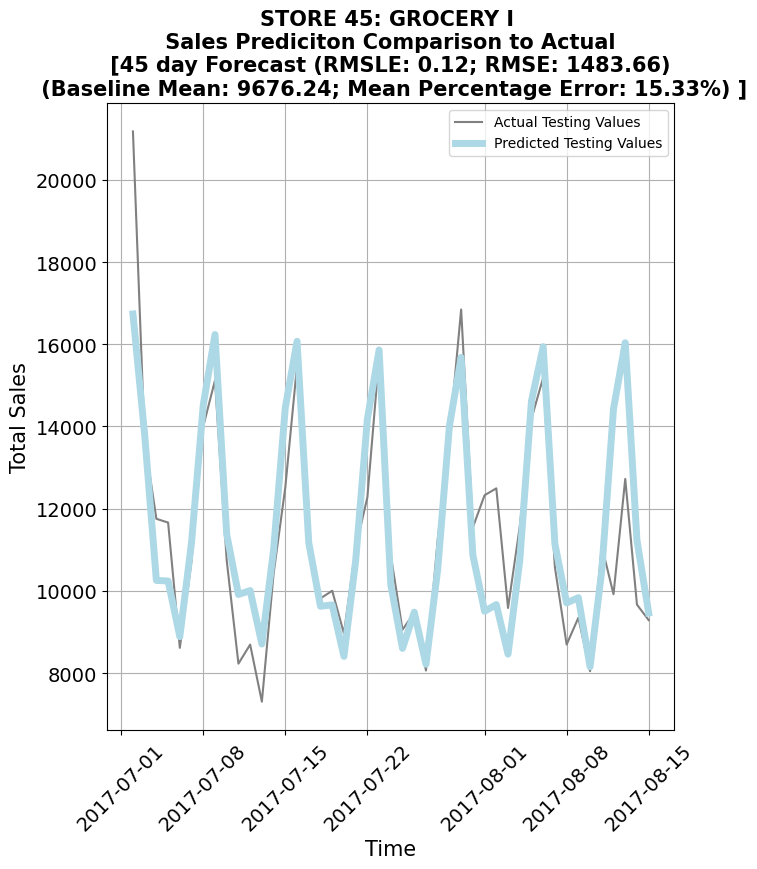

In [19]:
first_n_dates=30
last_n_dates=45 #30 days visually adhere's well

X_train, y_train, X_test, y_test = sinlge_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)

rmsle = np.sqrt(mean_squared_log_error(y_test_clipped, forecast_clipped))
rmse = np.sqrt(mean_squared_error(y_test_clipped, forecast_clipped))
target_mean = y_train.mean()
rmse_percentage = (rmse / target_mean) * 100



print("-----------------------------------")
print(f"RMSLE Score:{rmsle}")
print(f"RMSE Score:{rmse}")
print(f"Mean Score:{target_mean}")
print(f"RMSE as percentage of the mean: {rmse_percentage:.2f}%")



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))

plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (RMSLE: {rmsle.round(2)}; RMSE: {rmse.round(2)}) \n (Baseline Mean: {target_mean.round(2)}; Mean Percentage Error: {rmse_percentage.round(2)}%) ]", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../images/{last_n_dates}_day_model.png", format="png", dpi=300)

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:134: SettingWithCopyWarning: 
A value is trying to be set on a

-----------------------------------
RMSLE Score:0.12909633720161348
RMSE Score:1710.6989477009627
Mean Score:9614.385234205489
RMSE as percentage of the mean: 17.79%


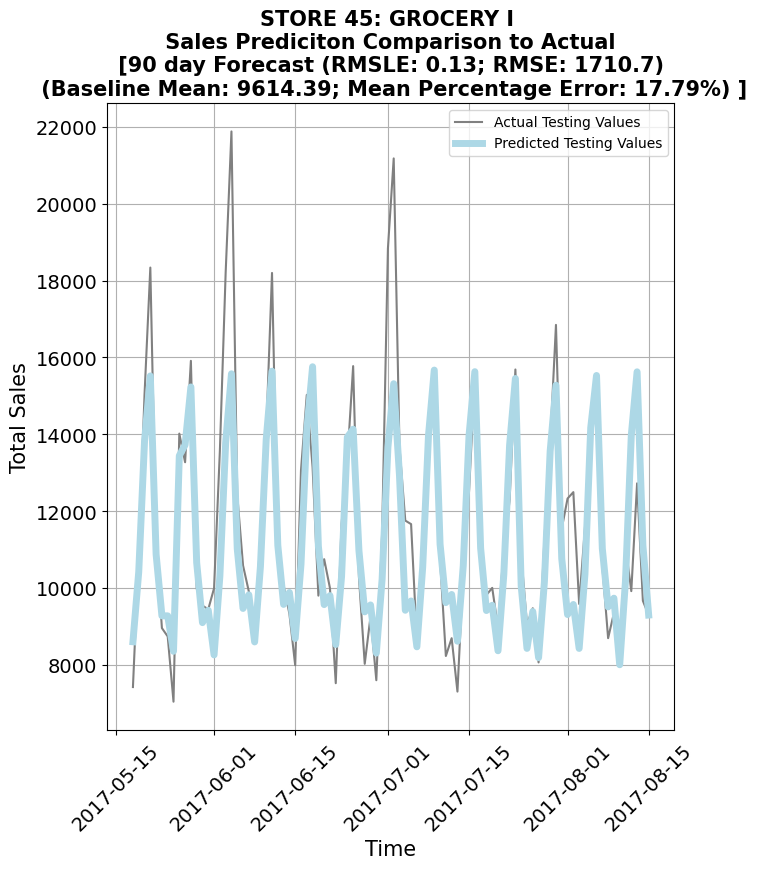

In [20]:
first_n_dates=30
last_n_dates=90 #30 days visually adhere's well

X_train, y_train, X_test, y_test = sinlge_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)

rmsle = np.sqrt(mean_squared_log_error(y_test_clipped, forecast_clipped))
rmse = np.sqrt(mean_squared_error(y_test_clipped, forecast_clipped))
target_mean = y_train.mean()
rmse_percentage = (rmse / target_mean) * 100



print("-----------------------------------")
print(f"RMSLE Score:{rmsle}")
print(f"RMSE Score:{rmse}")
print(f"Mean Score:{target_mean}")
print(f"RMSE as percentage of the mean: {rmse_percentage:.2f}%")



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))

plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (RMSLE: {rmsle.round(2)}; RMSE: {rmse.round(2)}) \n (Baseline Mean: {target_mean.round(2)}; Mean Percentage Error: {rmse_percentage.round(2)}%) ]", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../images/{last_n_dates}_day_model.png", format="png", dpi=300)

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:134: SettingWithCopyWarning: 
A value is trying to be set on a

-----------------------------------
RMSLE Score:0.260064296965414
RMSE Score:2360.5192560691353
Mean Score:9469.164970886934
RMSE as percentage of the mean: 24.93%


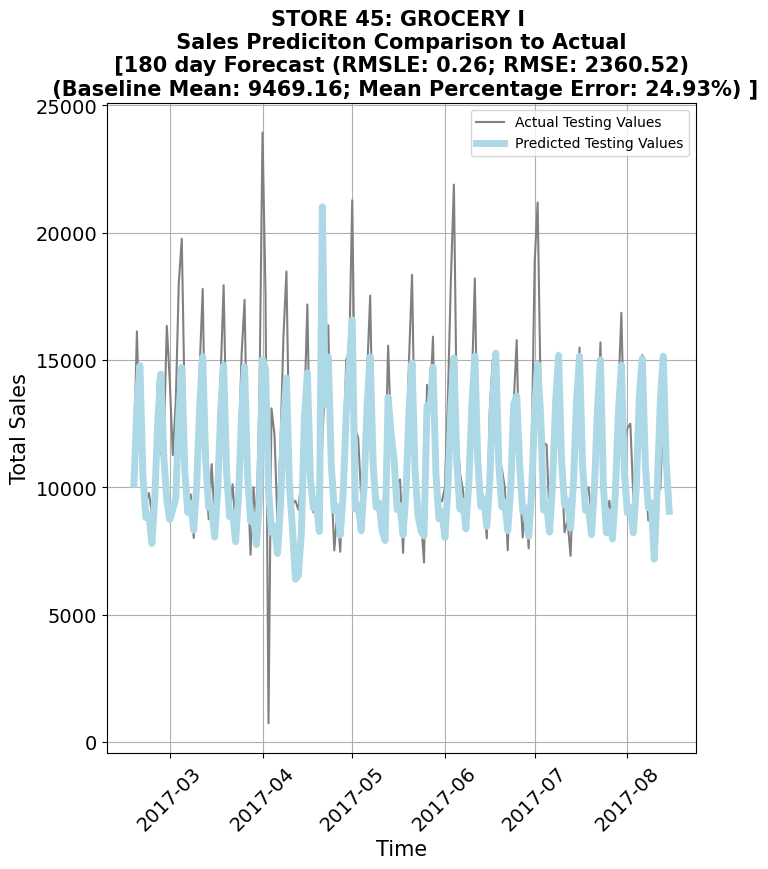

In [21]:
first_n_dates=30
last_n_dates=180 #30 days visually adhere's well

X_train, y_train, X_test, y_test = sinlge_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)

rmsle = np.sqrt(mean_squared_log_error(y_test_clipped, forecast_clipped))
rmse = np.sqrt(mean_squared_error(y_test_clipped, forecast_clipped))
target_mean = y_train.mean()
rmse_percentage = (rmse / target_mean) * 100



print("-----------------------------------")
print(f"RMSLE Score:{rmsle}")
print(f"RMSE Score:{rmse}")
print(f"Mean Score:{target_mean}")
print(f"RMSE as percentage of the mean: {rmse_percentage:.2f}%")



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))

plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (RMSLE: {rmsle.round(2)}; RMSE: {rmse.round(2)}) \n (Baseline Mean: {target_mean.round(2)}; Mean Percentage Error: {rmse_percentage.round(2)}%) ]", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../images/{last_n_dates}_day_model.png", format="png", dpi=300)

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:134: SettingWithCopyWarning: 
A value is trying to be set on a

-----------------------------------
RMSLE Score:0.5948143026909134
RMSE Score:3055.377857369076
Mean Score:9139.452451162791
RMSE as percentage of the mean: 33.43%


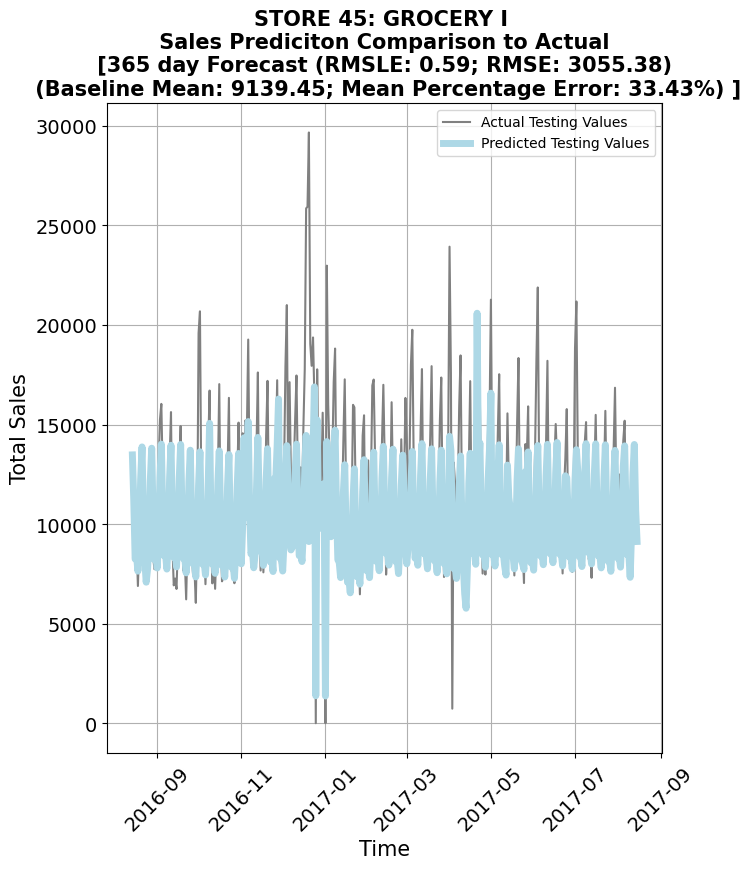

In [24]:
first_n_dates=30
last_n_dates=365 #30 days visually adhere's well

X_train, y_train, X_test, y_test = sinlge_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)

rmsle = np.sqrt(mean_squared_log_error(y_test_clipped, forecast_clipped))
rmse = np.sqrt(mean_squared_error(y_test_clipped, forecast_clipped))
target_mean = y_train.mean()
rmse_percentage = (rmse / target_mean) * 100



print("-----------------------------------")
print(f"RMSLE Score:{rmsle}")
print(f"RMSE Score:{rmse}")
print(f"Mean Score:{target_mean}")
print(f"RMSE as percentage of the mean: {rmse_percentage:.2f}%")



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))

plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (RMSLE: {rmsle.round(2)}; RMSE: {rmse.round(2)}) \n (Baseline Mean: {target_mean.round(2)}; Mean Percentage Error: {rmse_percentage.round(2)}%) ]", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../images/{last_n_dates}_day_model.png", format="png", dpi=300)

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_7647/86829594.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_plot_oil = interpolated_plot_oil.interpolate(method="linear")


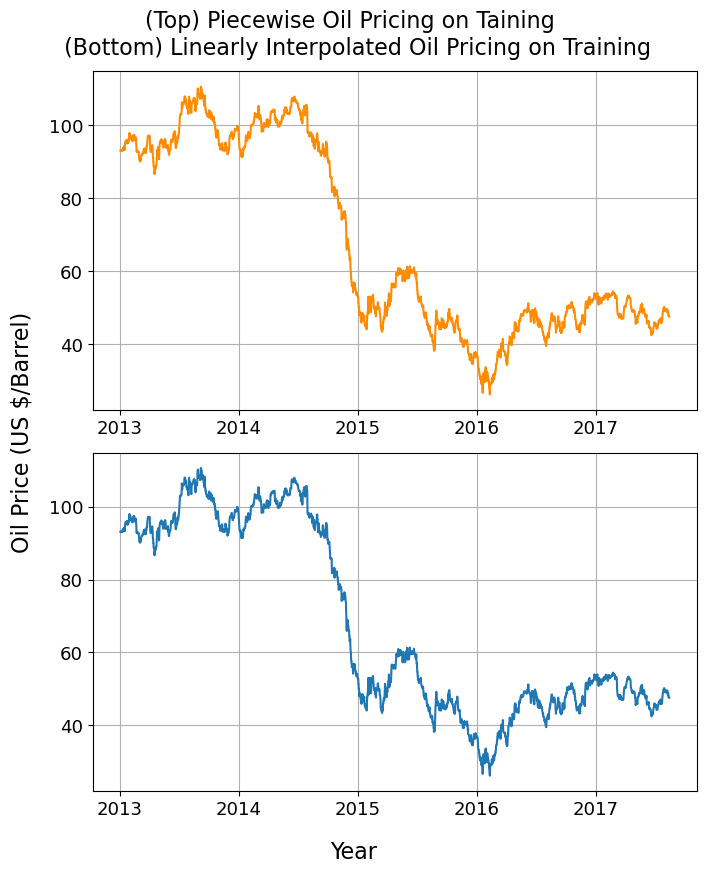

In [ ]:
##Notice that these plots won't show piecewise representation anymore
##Because the base_df has pre-interpolated values
##This interpolation line will need to be commented out in the oil cleaning funciton if the desire is to have a piecewise representation again for these plots. 

##For Grouped
grouped_plot_oil = base_df.copy()

grouped_plot_oil["group"] = (grouped_plot_oil["dol_per_barrel"].notnull() != grouped_plot_oil["dol_per_barrel"].notnull().shift()).cumsum() * grouped_plot_oil["dol_per_barrel"].notnull()

groups = grouped_plot_oil[ grouped_plot_oil["dol_per_barrel"].notnull() ].groupby("group")

grouped_plot_oil = grouped_plot_oil[ grouped_plot_oil["group"] != 0 ]

n_groups = groups.ngroups

#For interpolated
interpolated_plot_oil = base_df.copy()
interpolated_plot_oil = interpolated_plot_oil.interpolate(method="linear")


##Figure creation
fig, ax = plt.subplots(2, 1, figsize=(7.16, 8.8))#figsize=(11.69,8.27))

for group_id, group_data in groups:
    ax[0].plot(group_data["date"], group_data["dol_per_barrel"], color="darkorange", label=f"Oil Price Group {group_id}")

ax[1].plot(interpolated_plot_oil["date"], interpolated_plot_oil["dol_per_barrel"])


for index, a in enumerate(ax.flat):
    # Change the font weight of the x-ticks and y-ticks
    a.tick_params(axis='x', labelsize=13)  # Bold x-ticks
    a.tick_params(axis='y', labelsize=13)  # Bold y-ticks


ax[0].grid(which="both")
ax[1].grid(which="both")


plt.suptitle("(Top) Piecewise Oil Pricing on Taining \n (Bottom) Linearly Interpolated Oil Pricing on Training", size=16)
fig.supylabel("Oil Price (US $/Barrel)", fontsize=16)
fig.supxlabel("Year", fontsize=16)
plt.tight_layout()

plt.savefig("../images/training_oil_pre_post_interpolation.png", format="png", dpi=300)

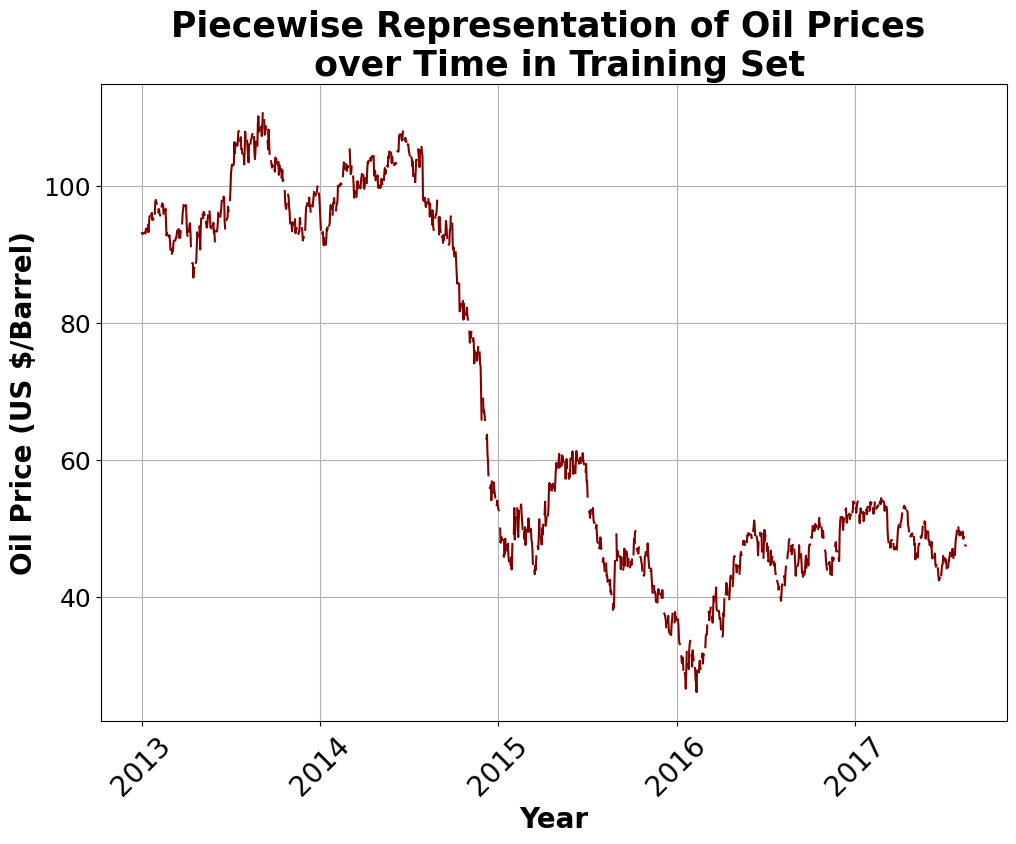

In [39]:
##Notice that these plots won't show piecewise representation anymore
##Because the base_df has pre-interpolated values
##This interpolation line will need to be commented out in the oil cleaning funciton if the desire is to have a piecewise representation again for these plots. 

model_training_date_range = base_df["date"].to_list()

oil_sub_dfs = []

plot_training_oil = base_df.copy()

plot_filter = ["date", "dol_per_barrel"]
plot_training_oil = plot_training_oil[plot_filter]

plot_training_oil["group"] = (plot_training_oil["dol_per_barrel"].notnull() != plot_training_oil["dol_per_barrel"].notnull().shift()).cumsum() * plot_training_oil["dol_per_barrel"].notnull()

groups = plot_training_oil[ plot_training_oil["dol_per_barrel"].notnull() ].groupby("group")

plot_training_oil = plot_training_oil[ plot_training_oil["group"] != 0 ]

n_groups = groups.ngroups

# fig, axes = plt.subplots(n_groups, 1, figsize = (30,20), sharex=True)
plt.figure( figsize=(11.69,8.27) )

# for (group_id, group_data), ax in zip(groups, axes):
for group_id, group_data in groups:
    plt.plot(group_data["date"], group_data["dol_per_barrel"], color="maroon", label=f"Oil Price Group {group_id}") #marker="o", color="blue"

plt.title("Piecewise Representation of Oil Prices \n over Time in Training Set", size=25, fontweight="bold")
plt.xlabel("Year", size=20, fontweight="bold")
plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

plt.xticks(size="20", rotation=45)
plt.yticks(size="18")
plt.grid(axis="both")

plt.savefig("../images/training_oil_piecewise_over_time.png", format="png", dpi=300)

In [40]:
#Testing data

# model_testing_date_range = model_testing["date"].to_list()

# oil_sub_dfs = []

# plot_testing_oil = model_testing.copy()

# plot_filter = ["date", "dol_per_barrel"]
# plot_testing_oil = plot_testing_oil[plot_filter]

# plot_testing_oil["group"] = (plot_testing_oil["dol_per_barrel"].notnull() != plot_testing_oil["dol_per_barrel"].notnull().shift()).cumsum() * plot_testing_oil["dol_per_barrel"].notnull()

# groups = plot_testing_oil[ plot_testing_oil["dol_per_barrel"].notnull() ].groupby("group")

# plot_testing_oil = plot_testing_oil[ plot_testing_oil["group"] != 0 ]

# n_groups = groups.ngroups

# # fig, axes = plt.subplots(n_groups, 1, figsize = (30,20), sharex=True)
# plt.figure( figsize=(11.69,8.27) )

# # for (group_id, group_data), ax in zip(groups, axes):
# for group_id, group_data in groups:
#     plt.plot(group_data["date"], group_data["dol_per_barrel"], color="maroon", label=f"Oil Price Group {group_id}") #marker="o", color="blue"

# plt.title("Piecewise Representation of Oil Prices \n over Time in Testing Set", size=25, fontweight="bold")
# plt.xlabel("Year", size=20, fontweight="bold")
# plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

# plt.xticks(size="20", rotation=45)
# plt.yticks(size="18")
# plt.grid(axis="both")

# plt.savefig("../images/testing_oil_piecewise_over_time.png", format="png", dpi=300)

# Encoding

# Store-family filtering

In [3]:
base_df = run_base_df()
base_df

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


Training


/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_32702/383304338.py:40: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


,date,store_nbr,family,sales,onpromotion,city,state,store_type,store_cluster,transactions,dol_per_barrel,holiday_type,locale,locale_name,holiday_description,transferred,rolling_30day_avg_traffic,rolling_15day_avg_traffic
0,2013-01-01,25,AUTOMOTIVE,0.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.000000
1,2013-01-01,25,BABY CARE,0.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.000000
2,2013-01-01,25,BEAUTY,2.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.000000
3,2013-01-01,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.000000
4,2013-01-01,25,BOOKS,0.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805226,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1964.6,2040.333333
2805227,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1964.6,2040.333333
2805228,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1964.6,2040.333333
2805229,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1964.6,2040.333333


In [4]:
store_agg_sales = (
    base_df
    .groupby(
        "store_nbr",
        as_index=False
    )["sales"]
    .agg(
        ["sum", "mean"]
    )
)
store_agg_sales['percentage'] = (store_agg_sales['sum'] / store_agg_sales['sum'].sum()) * 100

family_agg_sales = (
    base_df
    .groupby(
        "family",
        as_index=False
    )["sales"]
    .agg(
        ["sum", "mean"]
    )
)
family_agg_sales['percentage'] = (family_agg_sales['sum'] / family_agg_sales['sum'].sum()) * 100

store_family_agg_sales = (
    base_df
    .groupby(
        ["store_nbr","family"],
        as_index=False
    )["sales"]
    .agg(
        ["sum", "mean"]
    )
)
store_family_agg_sales['percentage'] = (store_family_agg_sales['sum'] / store_family_agg_sales['sum'].sum()) * 100

top_n_store_sales = store_agg_sales.sort_values("sum", ascending=False).head(10)
top_n_family_sales = family_agg_sales.sort_values("sum", ascending=False).head(10)
top_n_store_family_sales = store_family_agg_sales.sort_values("sum", ascending=False).head(10)

In [6]:
base_df["store_nbr"].nunique(0)

54

In [7]:
base_df["family"].nunique(0)

33

In [366]:
display(top_n_store_sales)
display(top_n_family_sales)
display(top_n_store_family_sales)

,store_nbr,sum,mean,percentage
43,44,6.322944e+07,1122.462523,5.778638
44,45,5.556440e+07,986.391134,5.078118
46,47,5.191405e+07,921.589322,4.744507
2,3,5.138214e+07,912.681524,4.695895
48,49,4.424617e+07,785.467427,4.043727
45,46,4.271543e+07,758.293422,3.903830
47,48,3.665941e+07,650.785710,3.350361
50,51,3.354408e+07,595.481735,3.065647
7,8,3.103776e+07,551.312007,2.836590
49,50,2.921806e+07,518.685227,2.670284


,family,sum,mean,percentage
12,GROCERY I,3.501477e+08,4119.045839,32.000554
3,BEVERAGES,2.210967e+08,2600.923736,20.206379
30,PRODUCE,1.250865e+08,1471.484349,11.431850
7,CLEANING,9.921556e+07,1167.145800,9.067467
8,DAIRY,6.569365e+07,772.802828,6.003846
5,BREAD/BAKERY,4.288346e+07,504.469700,3.919187
28,POULTRY,3.244274e+07,381.647830,2.964993
24,MEATS,3.160171e+07,371.754236,2.888130
25,PERSONAL CARE,2.503644e+07,294.522063,2.288120
9,DELI,2.453646e+07,288.640439,2.242426


,store_nbr,family,sum,mean,percentage
1464,45,GROCERY I,1.669191e+07,9778.505936,1.525500
1431,44,GROCERY I,1.668784e+07,9776.121163,1.525128
1530,47,GROCERY I,1.581651e+07,9265.676327,1.445496
1497,46,GROCERY I,1.461870e+07,8563.974224,1.336026
1422,44,BEVERAGES,1.366584e+07,8005.764499,1.248943
78,3,GROCERY I,1.320857e+07,7742.421562,1.207152
1563,48,GROCERY I,1.308679e+07,7666.541325,1.196022
1455,45,BEVERAGES,1.158282e+07,6785.480961,1.058572
69,3,BEVERAGES,1.154720e+07,6768.578546,1.055316
1596,49,GROCERY I,1.129970e+07,6619.623316,1.032697


In [129]:
display(store_family_agg_sales.sort_values("sum", ascending=False))

,store_nbr,family,sum,mean,percentage
1464,45,GROCERY I,1.669191e+07,9778.505936,1.525500
1431,44,GROCERY I,1.668784e+07,9776.121163,1.525128
1530,47,GROCERY I,1.581651e+07,9265.676327,1.445496
1497,46,GROCERY I,1.461870e+07,8563.974224,1.336026
1422,44,BEVERAGES,1.366584e+07,8005.764499,1.248943
...,...,...,...,...,...
1519,47,BABY CARE,0.000000e+00,0.000000,0.000000
1486,46,BABY CARE,0.000000e+00,0.000000,0.000000
1420,44,BABY CARE,0.000000e+00,0.000000,0.000000
1585,49,BABY CARE,0.000000e+00,0.000000,0.000000


## Day of Week Generation and Encoding

In [320]:
model_df = base_df.copy()
model_df = model_df[["date", "family", "sales", "dol_per_barrel", "rolling_15day_avg_traffic", "rolling_30day_avg_traffic", "store_nbr"]]

In [321]:
model_df.duplicated().sum()
model_df.index.duplicated().sum()

model_df = model_df[~model_df.index.duplicated(keep="first")]

print(model_df.duplicated().sum())
print(model_df.index.duplicated().sum())

0
0


In [322]:
model_df = pd.concat([model_df, niche_df, encoded_df], axis=1)

In [325]:
model_df.isnull().all().sum()

0

# Modeling 

In [327]:
model_df["date"].nunique()

1677

In [337]:
model_df = model_df[~model_df.index.duplicated(keep="first")]

# test_df = model_df.copy()
model_df.dropna(inplace=True)
model_df.sort_values(by=["date", "store_nbr", "family"], ascending=True)

first_n_dates = model_df["date"].drop_duplicates().head(365) 
last_15_dates = model_df["date"].drop_duplicates().tail(15) 

model_train = model_df[
    (~model_df["date"].isin(first_n_dates)) &
    (~model_df["date"].isin(last_15_dates))
]
model_test = model_df[
    (model_df["date"].isin(last_15_dates))
]

# model_train.set_index("date", inplace=True)
# model_test.set_index("date", inplace=True)

# model_train.set_index(["date", "store_nbr", "family"], inplace=True)
# model_test.set_index(["date", "store_nbr", "family"], inplace=True)

model_train = model_train[~model_train.index.duplicated(keep="first")]
model_test = model_test[~model_test.index.duplicated(keep="first")]


X_train = model_train.drop(columns=["sales", "family", "date"])
y_train = model_train["sales"]



X_test = model_test.drop(columns=["sales", "family", "date"])
y_test = model_test["sales"]

# print(model_train.shape)
# print(X_train.shape)
# print(y_train.shape)
# print(model_test.shape)
# print(X_test.shape)
# print(y_test.shape)



X_train.dropna(inplace=True)
y_train.dropna(inplace=True)

X_test.dropna(inplace=True)
y_test.dropna(inplace=True)


print(X_train.index.duplicated().any())
print(y_train.index.duplicated().any())

print(X_train.index.freq)
print(y_train.index.freq)



X_train = X_train.asfreq("D")
y_train = y_train.asfreq("D")

X_test = X_test.asfreq("D")
y_test = y_test.asfreq("D")

print(X_train.index.freq)
print(y_train.index.freq)

print(X_test.index.freq)
print(y_test.index.freq)

X_train.drop_duplicates(keep="first")
y_train.drop_duplicates(keep="first")

X_test.drop_duplicates(keep="first")
y_test.drop_duplicates(keep="first")

print(X_train.index.freq)
print(y_train.index.freq)

print(X_test.index.freq)
print(y_test.index.freq)


X_train.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)

X_test.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)


print(X_train.index.freq)
print(y_train.index.freq)

print(X_test.index.freq)
print(y_test.index.freq)

False
False
None
None
<Day>
<Day>
<Day>
<Day>
<Day>
<Day>
<Day>
<Day>
<Day>
<Day>
<Day>
<Day>


In [351]:
# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 1),                    # Default ARIMA order
    seasonal_order=(0, 0, 0, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)

rmsle = np.sqrt(mean_squared_log_error(y_test_clipped, forecast_clipped))

print(rmsle)
# Forecast
# forecast = model_fit.forecast()

0.1727885348237785


In [348]:
forecast

2017-08-01     9796.563148
2017-08-02     8257.639595
2017-08-03     8810.782614
2017-08-04    11110.465233
2017-08-05    13872.302736
2017-08-06    13892.515103
2017-08-07    12143.719393
2017-08-08     9642.380197
2017-08-09     8132.586245
2017-08-10     8626.956918
2017-08-11    10621.671060
2017-08-12    13397.005394
2017-08-13    13845.396102
2017-08-14    12109.067891
2017-08-15     8868.634121
Freq: D, Name: predicted_mean, dtype: float64

In [347]:
forecast.isnull().any()

False

In [350]:
rmsle = np.sqrt(mean_squared_log_error(y_test_clipped, forecast_clipped))

print(rmsle)

NameError: name 'y_test_clipped' is not defined

In [213]:
print(base_df.index.duplicated())

print(base_df.index[base_df.index.duplicated()])

list_index = base_df.index[base_df.index.duplicated()]
print(list_index)


test_df = base_df[
    base_df["date"].isin(list_index)
]

new_df = test_df.drop_duplicates()
new_df = new_df[
    base_df["date"].isin(list_index)
]
new_df.shape

[False False False ... False False False]
DatetimeIndex(['2013-05-12', '2013-06-25', '2013-06-25', '2013-07-03',
               '2013-12-22', '2014-06-25', '2014-06-25', '2014-06-25',
               '2014-07-03', '2014-12-22', '2014-12-26', '2015-06-25',
               '2015-06-25', '2015-07-03', '2015-12-22', '2016-04-21',
               '2016-05-01', '2016-05-07', '2016-05-08', '2016-05-12',
               '2016-06-25', '2016-06-25', '2016-07-03', '2016-07-24',
               '2016-11-12', '2016-12-22', '2017-04-14', '2017-06-25',
               '2017-06-25', '2017-07-03'],
              dtype='datetime64[ns]', name='date_index', freq=None)
DatetimeIndex(['2013-05-12', '2013-06-25', '2013-06-25', '2013-07-03',
               '2013-12-22', '2014-06-25', '2014-06-25', '2014-06-25',
               '2014-07-03', '2014-12-22', '2014-12-26', '2015-06-25',
               '2015-06-25', '2015-07-03', '2015-12-22', '2016-04-21',
               '2016-05-01', '2016-05-07', '2016-05-08', '2016-05

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_7647/2549545053.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_df = new_df[


(54, 19)

In [342]:
# Perform ADF test
start_time = time.time()

result = adfuller(_train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

end_time = time.time()
time_differential =  end_time - start_time
print(time_differential)

ADF Statistic: -5.085156213369393
p-value: 1.5015166785427708e-05
0.044599056243896484


In [91]:
# Forecast with test exogenous variables
forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

# View forecasted values
print(forecast)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [92]:
y_train.index

MultiIndex([('2014-01-03', 1,                 'AUTOMOTIVE'),
            ('2014-01-03', 1,                  'BABY CARE'),
            ('2014-01-03', 1,                     'BEAUTY'),
            ('2014-01-03', 1,                  'BEVERAGES'),
            ('2014-01-03', 1,                      'BOOKS'),
            ('2014-01-03', 1,               'BREAD/BAKERY'),
            ('2014-01-03', 1,                'CELEBRATION'),
            ('2014-01-03', 1,                   'CLEANING'),
            ('2014-01-03', 1,                      'DAIRY'),
            ('2014-01-03', 1,                       'DELI'),
            ...
            ('2017-07-31', 9,                  'MAGAZINES'),
            ('2017-07-31', 9,                      'MEATS'),
            ('2017-07-31', 9,              'PERSONAL CARE'),
            ('2017-07-31', 9,               'PET SUPPLIES'),
            ('2017-07-31', 9,    'PLAYERS AND ELECTRONICS'),
            ('2017-07-31', 9,                    'POULTRY'),
        

In [93]:
y_test.index

MultiIndex([('2017-08-01', 1,                 'AUTOMOTIVE'),
            ('2017-08-01', 1,                  'BABY CARE'),
            ('2017-08-01', 1,                     'BEAUTY'),
            ('2017-08-01', 1,                  'BEVERAGES'),
            ('2017-08-01', 1,                      'BOOKS'),
            ('2017-08-01', 1,               'BREAD/BAKERY'),
            ('2017-08-01', 1,                'CELEBRATION'),
            ('2017-08-01', 1,                   'CLEANING'),
            ('2017-08-01', 1,                      'DAIRY'),
            ('2017-08-01', 1,                       'DELI'),
            ...
            ('2017-08-15', 9,                  'MAGAZINES'),
            ('2017-08-15', 9,                      'MEATS'),
            ('2017-08-15', 9,              'PERSONAL CARE'),
            ('2017-08-15', 9,               'PET SUPPLIES'),
            ('2017-08-15', 9,    'PLAYERS AND ELECTRONICS'),
            ('2017-08-15', 9,                    'POULTRY'),
        

In [61]:
model_train.dtypes

date                                 datetime64[ns]
sales                                       float64
dol_per_barrel                              float64
rolling_15day_avg_traffic                   float64
rolling_30day_avg_traffic                   float64
                                          ...      
holiday_description_Viernes Santo           float64
holiday_description_nan                     float64
transferred_False                           float64
transferred_True                            float64
transferred_nan                             float64
Length: 188, dtype: object

# Feature Creation

- sales by transactions to get an average sale per transaction

In [ ]:
#training and test

training_y = df.iloc[:-]